Unfortunately, there is also no way of programmatically getting at the information that USGS staff have put together for their profile pages, so I had to come up with a scraper for that information. I put this into a single function that operates against a given staff profile URL and am currently limiting the work to anything that we can't get from other sources. The interesting bits include a set of keywords, drawn from the USGS Thesaurus, that represent self-assertions of expertise. The other main section that an individual can control themselves is a big body of HTML. We might be able to work through this content with further processing, but for now, I shove that into a string and extract all of the links from it in a list. The links often include publications that are not otherwise part of the listing coming from official channels, which can be a very useful addendum to a research record.

As an example of working with this capability, this notebook picks up on some work that Leslie Hsu started for the USGS Community for Data Integration. We focus in on CDI members from USGS with staff profiles, scrape up all of their expertise keywords, and then work through the results. There's more to do here in terms of analysis with the keywords that we'll get into elsewhere.

In [1]:
%matplotlib inline
import pylinkedcmd.pylinkedcmd as l_cmd
from joblib import Parallel, delayed
import tqdm
import pickle
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

usgs_web = l_cmd.UsgsWeb()

In [2]:
infile = open("usgs_staff.pkl", "rb")
usgs_staff = pickle.load(infile)
infile.close()

CDI Members are all part of a group in Confluence used for the CDI wiki. Unfortunately, the API for that is not public and I didn't figure out how to authenticate, so I logged in through a web browser and saved the API response for the group as a JSON file. I then get just CDI members who have usgs.gov email addresses (usernames) and figure out which ones have listings in our profiles data.

In [3]:
with open("cdi_members.json", "r") as f:
    cdi_members = json.load(f)
    f.close()
    
cdi_members_usgs = [
    {
        "email": i["username"], 
        "name": i["displayName"]
    } for i in cdi_members["results"] if i["username"].split("@")[-1] == "usgs.gov"
]

cdi_member_staff = [
    i for i in usgs_staff
    if next((e for e in i["email"] if e is not None and e in [m["email"] for m in cdi_members_usgs]), None) is not None
]

cdi_member_profile_urls = [i["profile"][0] for i in cdi_member_staff if i["profile"][0] is not None]

Taking a quick look at the numbers, we have 10 CDI members with USGS user names who were not in the staff listing. These are possibly former USGS staff. Of those, there is only one that does not have a profile page. So, we have a lot to work with.

In [4]:
print("USGS CDI Members", len(cdi_members_usgs))
print("USGS CDI Members from USGS staff listing", len(cdi_member_staff))
print("USGS CDI Members with profile paes", len(cdi_member_profile_urls))
print("Members with more than one profile page", len([i for i in cdi_member_staff if len(i["profile"]) > 1]))

USGS CDI Members 118
USGS CDI Members from USGS staff listing 108
USGS CDI Members with profile paes 107
Members with more than one profile page 0


This accumulator function will build a list of dictionaries containing member profiles from our parallel process.

In [5]:
cdi_member_profiles = list()

def accumulator(url):
    cdi_member_profiles.append(usgs_web.scrape_profile(url))

In [6]:
Parallel(n_jobs=10, prefer="threads")(
    delayed(accumulator)
    (
        i
    ) for i in tqdm.tqdm(cdi_member_profile_urls)
)

100%|██████████| 107/107 [00:30<00:00,  3.47it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Here we pull out just the raw expertise keywords into their own list for a quick look.

In [7]:
%%capture
expertise_keywords = list()
[expertise_keywords.extend(i["expertise"]) for i in cdi_member_profiles if "expertise" in i.keys()]

In [8]:
expertise_keywords

['Data science',
 'Ecology',
 'Biogeochemistry',
 'Rivers and streams',
 'Machine learning',
 'Modeling',
 'geographic information science',
 'hydrologic modeling',
 'watershed hydrology',
 'Rivers',
 'Geomorphology',
 'Hydrology',
 'Dams',
 'groundwater flow',
 'groundwater level',
 'hydrology',
 'saltwater intrusion',
 'groundwater',
 'groundwater quality',
 'water use',
 'field methods',
 'decision support',
 'collaborative learning',
 'environmental decision making',
 'policy analysis',
 'Sediment Transport ',
 'Water Level Dynamics',
 'Coastal Ocean Modeling',
 'Hydrology',
 'Contaminant Hydrogeology',
 'Water Balance',
 'Groundwater modeling',
 'aquifer characterization',
 'hydrogeologic framework',
 'hydrogeophysics',
 'groundwater flow',
 'fractured rock',
 'karst',
 'aquifer testing',
 'groundwater-surface water interaction',
 'landslides',
 'PFAS',
 'groundwater remediation',
 'passive sampling',
 'Groundwater',
 'surface water (non-marine)',
 'surface water quality',
 'water

Without further work to associate expertise keywords with the USGS Thesaurus or other vocabulary resources, the list is a bit crude. But we can give it a quick look with a wordcloud just to visualize raw words coming together so far. This is all words and not keyword phrases at this point.

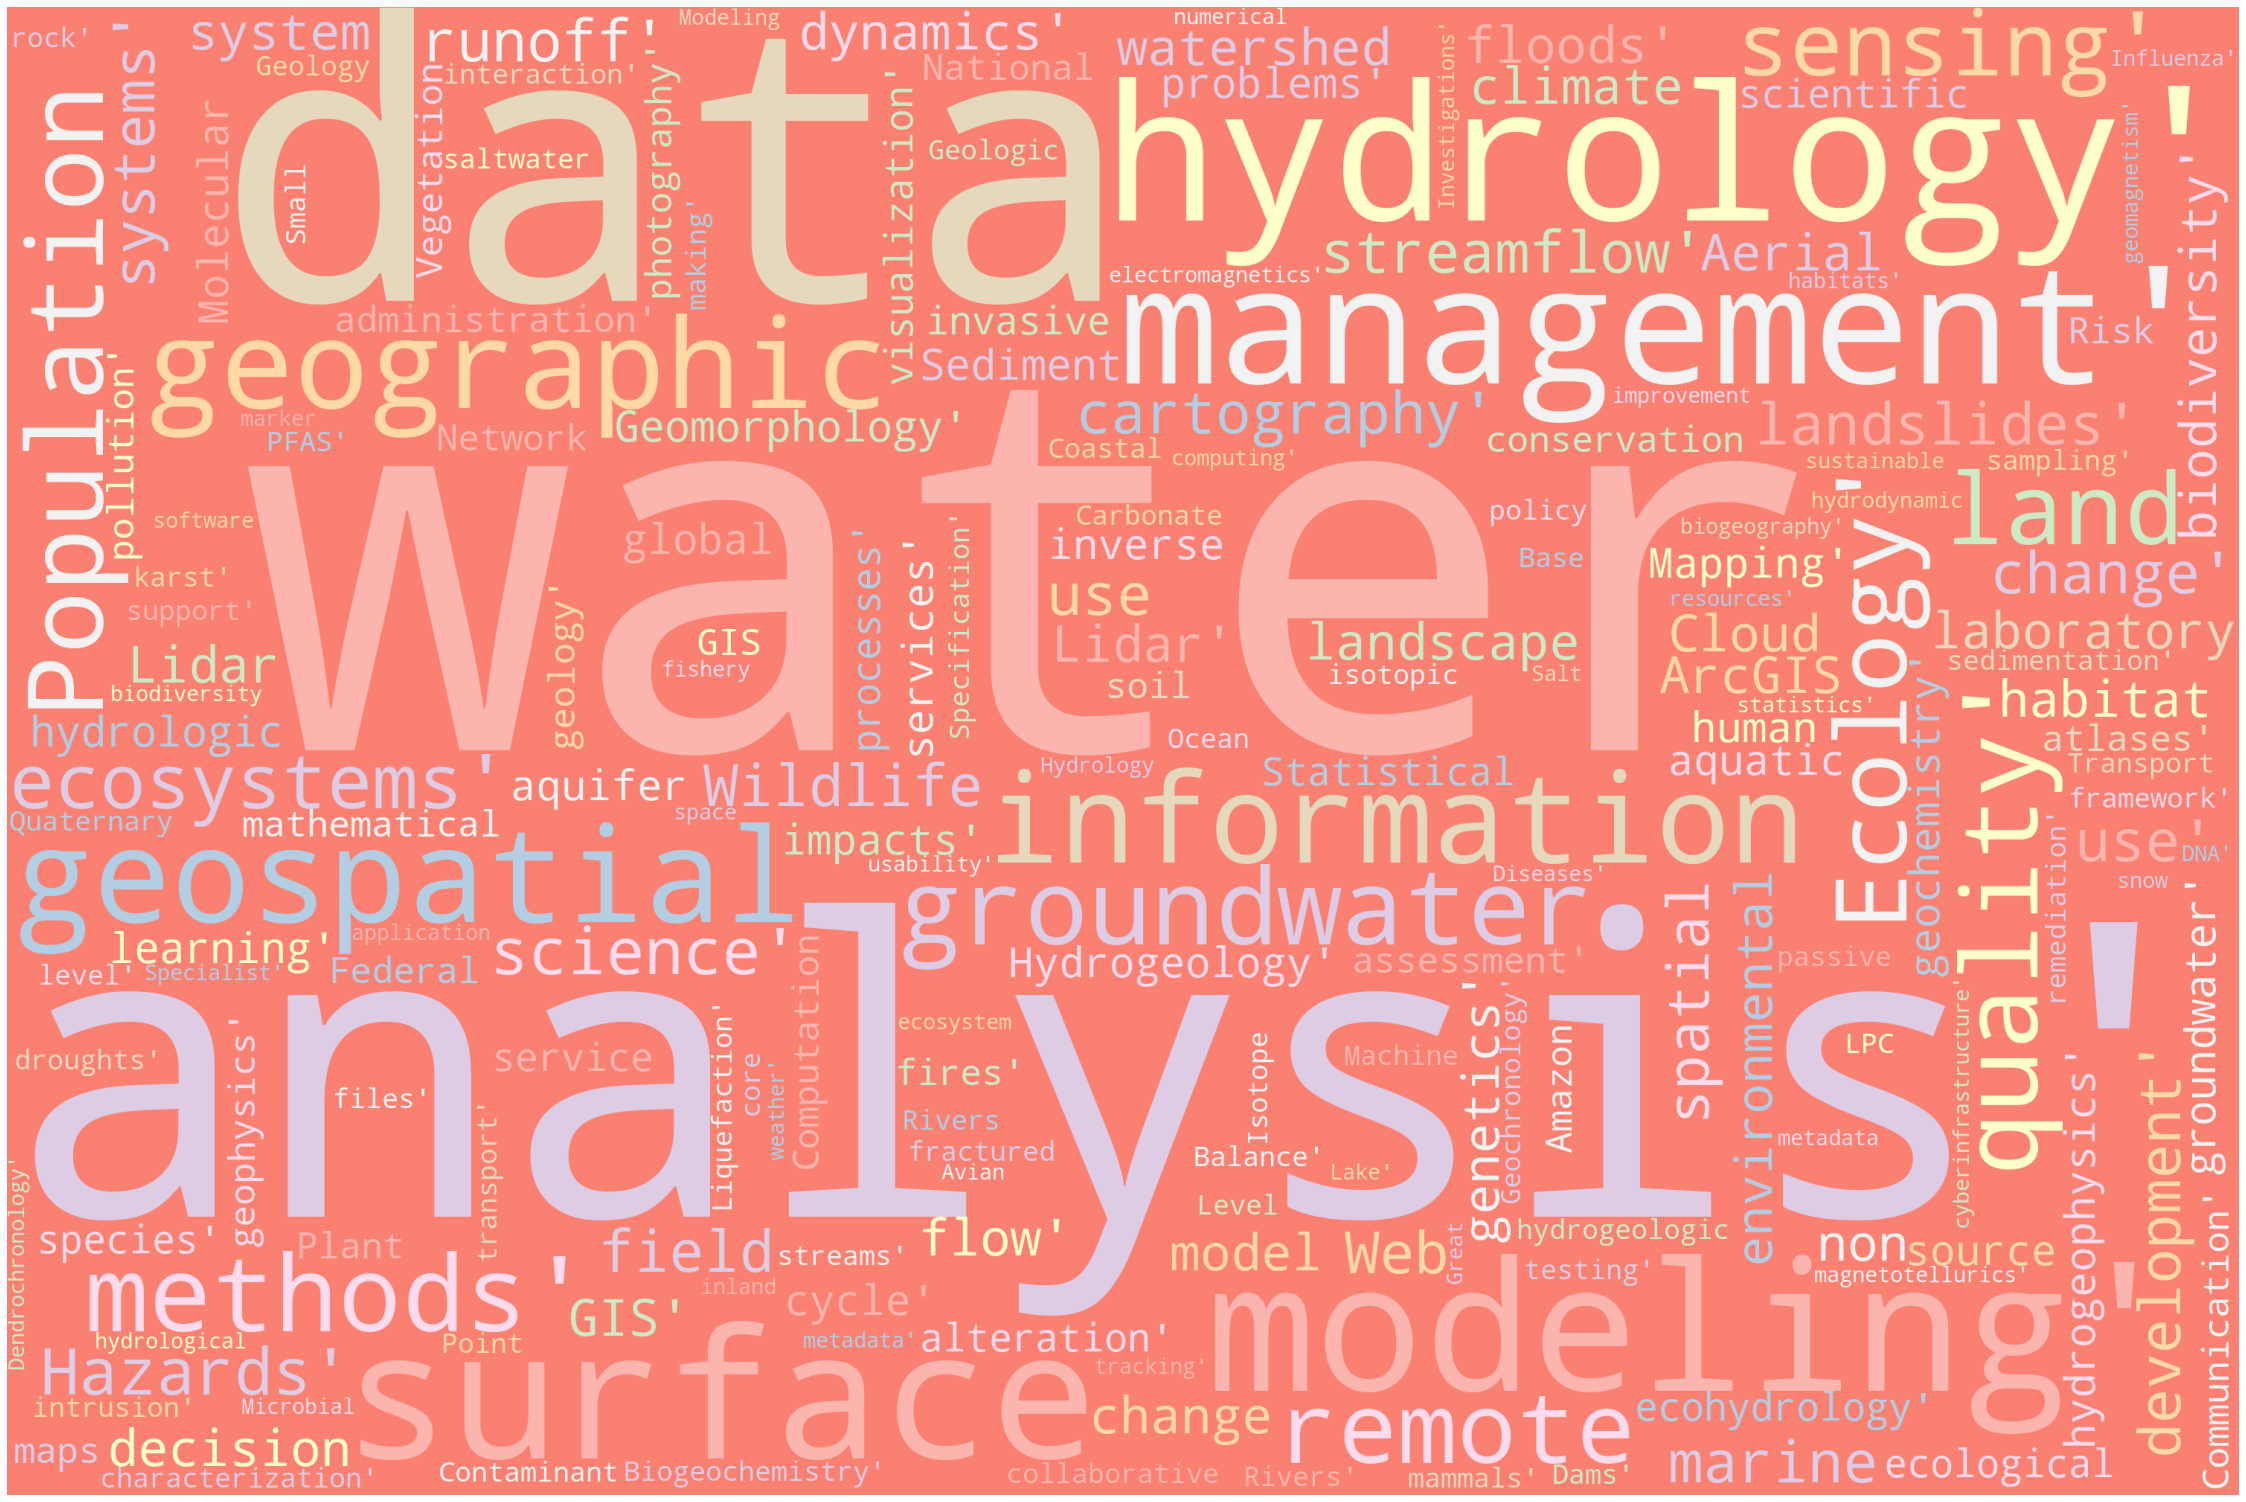

In [9]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(
    width = 3000, 
    height = 2000, 
    random_state=1, 
    background_color='salmon', 
    colormap='Pastel1', 
    collocations=False, 
    stopwords = STOPWORDS
).generate(str(expertise_keywords))

plot_cloud(wordcloud)